# 계층적 클러스터링

##### SetUp

pip install numpy pandas scipy
pip install -U scikit-learn
pip install matplotlib seaborn
pip install tqdm joblib shap lime

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

##### Conifg

In [28]:
DATA_PATH = "./data/"
PATH = os.path.join(DATA_PATH, "penguins.csv")

##### Data

In [29]:
df = pd.read_csv(PATH)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


## Clustering

In [30]:
num_col = df.select_dtypes(include=[np.number]).columns.to_list() # 연속형 컬럴만 선택 후 리스트
num_col

['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [31]:
df = df[num_col]
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
dtypes: float64(4)
memory usage: 10.9 KB


In [33]:
round(df.describe(), 2)


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.00,342.00,342.00,342.00
mean,43.92,17.15,214.01,4201.75
std,5.46,1.97,260.56,801.95
min,32.10,13.10,-132.00,2700.00
25%,39.22,15.60,190.00,3550.00
50%,44.45,17.30,197.00,4050.00
75%,48.50,18.70,213.75,4750.00
max,59.60,21.50,5000.00,6300.00


### 전처리

In [34]:
df.isna().sum() # 적어서 그냥 날림

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

In [35]:
df = df.dropna(axis=0)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [38]:
df.shape

(342, 4)

### 스케일링
변수간 불균형을 없애줌

#### 표준화
$z=\frac{x−μ}{\sigma}​$

평균 0, 분산 $1^2$로 맞춰줌
<p>

**장점**
- 이상치 덜 민감(min-max보다)   
<p>

**단점**
- 분포의 영향을 받음(정규분포에 근사해야 적합)
- 이상치에 여전히 민감

In [43]:
mu = df.mean(axis=0).to_numpy()
sd = df.std(axis=0, ddof=1).replace(0, 1).to_numpy() # 분모가 0이 되는것을 방지(분산 0 방지)
x = (df.to_numpy()-mu) / sd
df = pd.DataFrame(x, columns=num_col)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-0.883205,0.784300,-0.126707,-0.563317
1,-0.809939,0.126003,-0.107518,-0.500969
2,-0.663408,0.429833,-0.072977,-1.186793
3,-1.322799,1.088129,-0.080652,-0.937403
4,-0.846572,1.746426,-0.092166,-0.688012


#### Min-Max(민맥스)

$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$

[0, 1]로 맞춰줌
<p>

**장점**
- 분포가 변하지 않아(선형 변환) 신경망의 input(딥러닝의 input)으로 자주 사용 - 생각없이 사용할 때 주로 사용
<p>

**단점**
- 이상치에 민감(스케일을 강제로 [0, 1]로 맞추기에)
  


In [ ]:
# temp = df.to_numpy()
# min = temp.min(axis=0)
# max = temp.max(axis=0)

# x = (temp-min)/(max-min+1e-8) # 1e-8 : 아주 작은 값을 더해서, 분모 0 방지

#### Robust(4분위수 활용)

$x' = \frac{x - median}{Q3 - Q1}$

4분위수 기준, IQR활용
<p>

**장점**
- 이상치에 강함
- 분포가 치우쳐도 안정적
<p>

**단점**
- 정규분포라면 표준화보다 성능 낮음
- 범위고정 못함(0~1, -1~1을 못만듦) : 범위에 무관한 트리모델이 아니면 생각보다 치명적

In [39]:
# temp = df.to_numpy()
# median = np.median(temp, axis=0)
# q1 = np.percentile(temp, 25, axis=0)
# q3 = np.percentile(temp, 75, axis=0)

# x = (temp-median)/(q3-q1+1e-8)

### 모델링

#### Linakge

In [47]:
x_single   = linkage(x, method="single",   metric="euclidean")
x_complete = linkage(x, method="complete", metric="euclidean")
x_average  = linkage(x, method="average",  metric="euclidean")

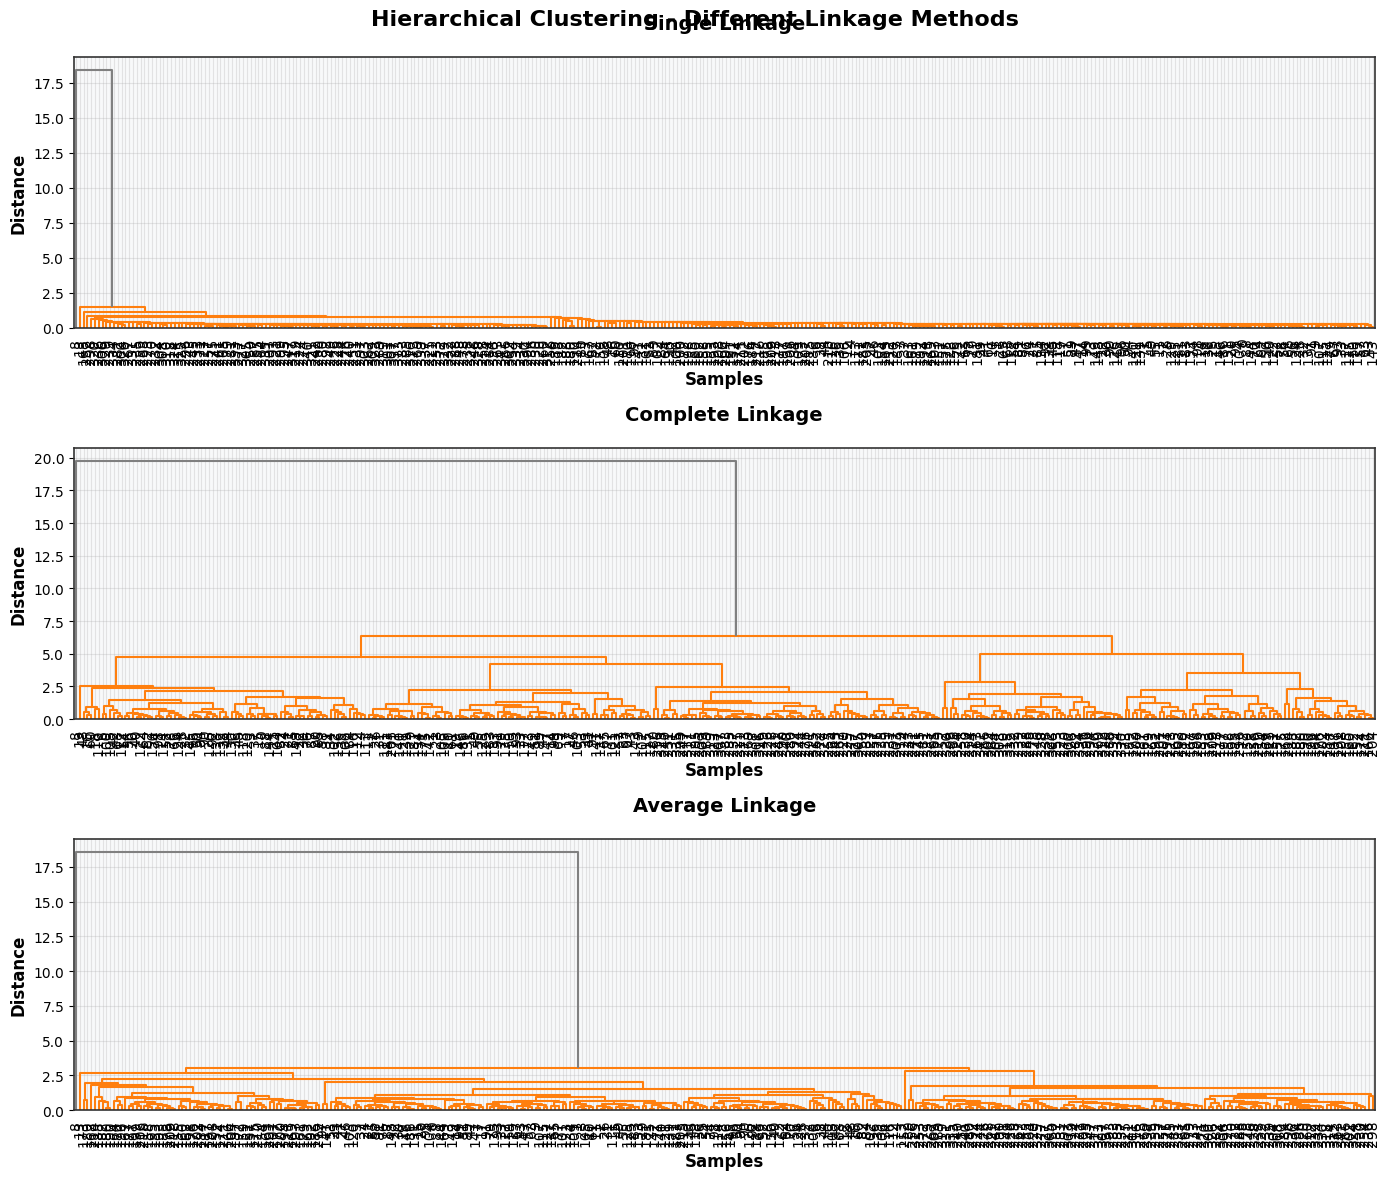

In [ ]:
# 시각화 설정 - 지선생님 활용
plt.style.use('default')
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Single linkage 덴드로그램
dendrogram(x_single, 
           labels=[str(i) for i in range(len(x))], 
           ax=axes[0], 
           color_threshold=0.7*max(x_single[:,2]),
           above_threshold_color='gray')
axes[0].set_title("Single Linkage", fontsize=14, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.3)

# Complete linkage 덴드로그램
dendrogram(x_complete, 
           labels=[str(i) for i in range(len(x))], 
           ax=axes[1], 
           color_threshold=0.7*max(x_complete[:,2]),
           above_threshold_color='gray')
axes[1].set_title("Complete Linkage", fontsize=14, fontweight='bold', pad=20)
axes[1].grid(True, alpha=0.3)

# Average linkage 덴드로그램
dendrogram(x_average, 
           labels=[str(i) for i in range(len(x))], 
           ax=axes[2], 
           color_threshold=0.7*max(x_average[:,2]),
           above_threshold_color='gray')
axes[2].set_title("Average Linkage", fontsize=14, fontweight='bold', pad=20)
axes[2].grid(True, alpha=0.3)

# 축 레이블 설정
for i, ax in enumerate(axes):
    ax.set_xlabel("Samples", fontsize=12, fontweight='bold')
    ax.set_ylabel("Distance", fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # 배경색 설정
    ax.set_facecolor('#f8f9fa')
    
    # 테두리 스타일
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#333333')

plt.suptitle("Hierarchical Clustering - Different Linkage Methods", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

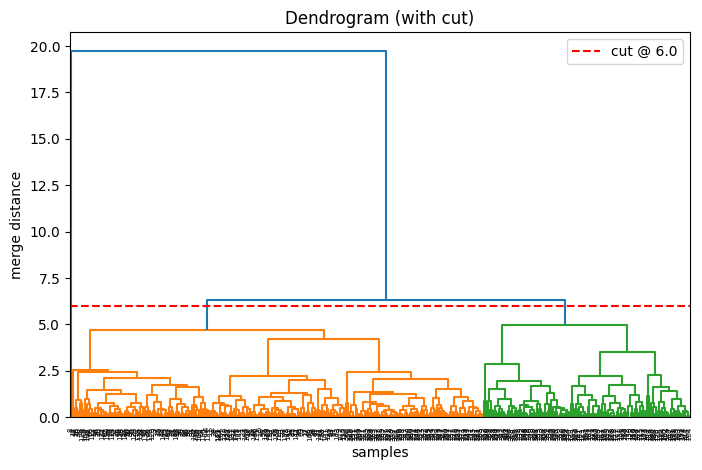

cluster
1    227
2    114
3      1
Name: count, dtype: int64

In [61]:
# Cell 3) (옵션) 덴드로그램 한 장만 크게 그리고, 컷 높이/클러스터 수 조절해 라벨 얻기 # 지선생님 활용
LINKAGE = x_complete  # 여기서 원하는 Z_* 중 하나 선택: Z_single / Z_complete / Z_average
CUT_HEIGHT = 6.0        # 덴드로그램 y축 상에서 자를 높이(데이터에 맞게 조절)
CLUSTERS = 3     # 개수로 자르고 싶다면 아래 fcluster에서 criterion='maxclust' 사용

fig, ax = plt.subplots(figsize=(8, 5))
dendrogram(LINKAGE, labels=[str(i) for i in range(len(x))], ax=ax, color_threshold=CUT_HEIGHT)
ax.axhline(CUT_HEIGHT, ls="--", c="red", label=f"cut @ {CUT_HEIGHT}")
ax.set_title("Dendrogram (with cut)")
ax.set_xlabel("samples"); ax.set_ylabel("merge distance"); ax.legend()
plt.show()

# 라벨 얻기 (클러스터 개수 기준)
labels_h = fcluster(LINKAGE, t=CLUSTERS, criterion='maxclust')
pd.Series(labels_h, name="cluster").value_counts().sort_index()

In [62]:
# 클러스터 라벨을 추가한 데이터프레임 생성
df_clustered = df.copy()
df_clustered['cluster'] = labels_h

print("클러스터별 데이터 분포:")
print(df_clustered['cluster'].value_counts().sort_index())
print("\n" + "="*50 + "\n")

print("클러스터가 추가된 데이터프레임:")
print(df_clustered.head(10))

print(f"\n데이터프레임 크기: {df_clustered.shape}")
print(f"클러스터 개수: {df_clustered['cluster'].nunique()}")

# 클러스터별 평균값 확인
print("\n클러스터별 특성 평균값:")
cluster_means = df_clustered.groupby('cluster').mean().round(3)
print(cluster_means)

클러스터별 데이터 분포:
cluster
1    227
2    114
3      1
Name: count, dtype: int64


클러스터가 추가된 데이터프레임:
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  cluster
0         -0.883205         0.784300          -0.126707    -0.563317        1
1         -0.809939         0.126003          -0.107518    -0.500969        1
2         -0.663408         0.429833          -0.072977    -1.186793        1
3         -1.322799         1.088129          -0.080652    -0.937403        1
4         -0.846572         1.746426          -0.092166    -0.688012        1
5         -0.919837         0.328556          -0.126707    -0.719186        1
6         -0.864888         1.240044          -0.072977     0.590115        1
7         -1.799025         0.480471          -0.080652    -0.906229        1
8         -0.352029         1.543873          18.368211     0.060160        3
9         -1.121318        -0.025911          -0.107518    -1.124446        1

데이터프레임 크기: (342, 5)
클러스터 개수: 3

클러스터별 특성 평균값:
